Importing Libraries


In [4]:
import csv
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy.stats import norm
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from scipy import stats

Loading Dataset


In [ ]:
fashion_mnist = fetch_openml(data_id=40996,as_frame=False,parser="auto")
fashion_mnist.data.shape

(70000, 784)

In [ ]:
# 0 T-shirt/top
# 1 Trouser
# 2 Pullover
# 3 Dress
# 4 Coat
# 5 Sandal
# 6 Shirt
# 7 Sneaker
# 8 Bag
# 9 Ankle boot

Preprocessing Data

In [ ]:
X = fashion_mnist.data.astype('float32')
y = fashion_mnist.target.astype('int64')
# noise = np.random.normal(0, 0.1, X.shape)
# X_noise = X + noise
# noisy_array = np.clip(noisy_array, 0, 1)

In [ ]:
def plot_example(X, y,k=5):
    """Plot the first 5 images and their labels in a row."""
    plt.figure(figsize=(10,6))
    for i, (img, y) in enumerate(zip(X[:k].reshape(k, 28, 28), y[:k])):
        plt.subplot(1,k,1+i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

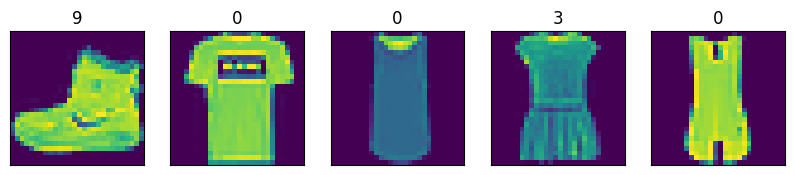

In [ ]:
plot_example(X, y)

Split Data

In [ ]:
X_splits = {}
y_splits = {}
unique_labels = np.unique(y)
for label in unique_labels:
    X_splits[label] = X[y == label]
    y_splits[label] = y[y == label]


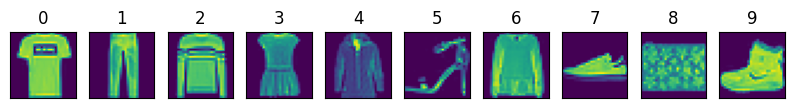

In [ ]:
sample_X = []
sample_y = []
for i in range(10):
    sample_X.append(X_splits[i][0])
    sample_y.append(y_splits[i][0])
sample_X = np.array(sample_X)
sample_y = np.array(sample_y)
plot_example(sample_X,sample_y,k=10)

In [ ]:
X_26 = np.concatenate((X_splits[2],X_splits[6]),axis=0)
y_26 = np.concatenate((y_splits[2],y_splits[6]))

In [ ]:
print(X_26.shape,y_26.shape)

(14000, 784) (14000,)


In [ ]:
y_26_oh = y_26.copy()
y_26_oh[y_26_oh == 2] = 1
y_26_oh[y_26_oh == 6] = 0

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_26,y_26_oh, test_size=0.20, random_state=42,shuffle=True)

In [ ]:
np.unique(y_train,return_counts=True)

(array([0, 1]), array([5615, 5585]))

In [ ]:
np.unique(y_test,return_counts=True)

(array([0, 1]), array([1385, 1415]))

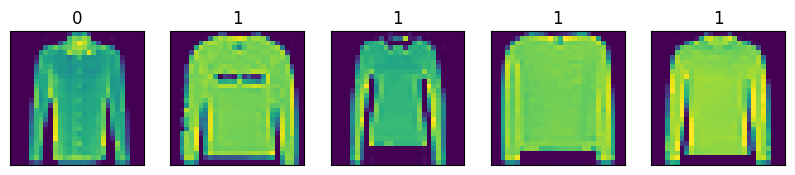

In [ ]:
plot_example(X_train, y_train)

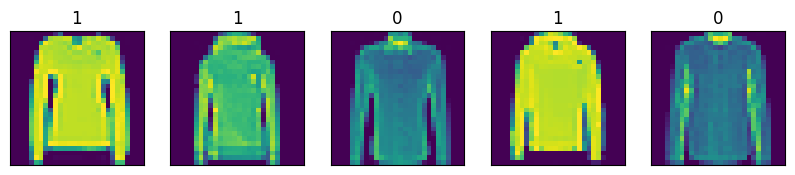

In [ ]:
plot_example(X_test, y_test)

In [ ]:

def write_to_csv(data,csv_file_path):
    # Check if the CSV file exists
    if os.path.exists(csv_file_path):
        # Read the existing data from the CSV file
        existing_data = pd.read_csv(csv_file_path, header=None).values.tolist()
    else:
        existing_data = []

    # Transpose the data to write it in columns
    data = [data]  # Convert data into a list of lists
    data = list(map(list, zip(*data)))  # Transpose the data

    # Append the new data to the existing data
    if existing_data:
        for i in range(min(len(existing_data), len(data))):
            existing_data[i].extend(data[i])
    else:
        existing_data = data

    # Write the combined data to the CSV file
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)

        # Write the data to the CSV file column-wise
        for row in existing_data:
            writer.writerow(row)

In [ ]:
def sampling(n,input,output,replace=False):
    indices = np.random.choice(len(input),n,replace=replace)
    bootstrap_X = X_train[indices]
    bootstrap_y = y_train[indices]
    return bootstrap_X,bootstrap_y

def create_model():
    model = keras.Sequential()
    model.add(layers.Input(shape=(784,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_table(model,input,output):
    pred = model.predict(input)
    pred[pred>=0.5] = 1
    pred[pred<0.5] = 0
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0

    # Calculate confusion matrix values
    for i in range(len(pred)):
        if output[i] == 1 and pred[i] == 1:
            true_positives += 1
        elif output[i] == 0 and pred[i] == 0:
            true_negatives += 1
        elif output[i] == 0 and pred[i] == 1:
            false_positives += 1
        elif output[i] == 1 and pred[i] == 0:
            false_negatives += 1

    # Create the confusion matrix as a list of lists
    confusion_matrix_result = [[true_negatives, false_positives],
                            [false_negatives, true_positives]]

    # Convert the confusion matrix to a numpy array for better visualization (optional)
    confusion_matrix_array = np.array(confusion_matrix_result)
    return confusion_matrix_array

def joint_odds_ratio(tables):
    k = len(tables)
    num = 0
    den = 0
    for i in range(k):
        sum = tables[i][0][0] + tables[i][0][1] + tables[i][1][1] + tables[i][1][0]
        num = num + (tables[i][0][0]*tables[i][1][1])/sum
        den = den + (tables[i][0][1]*tables[i][1][0])/sum
    return num/den

def odds_ratio(table):
    pA = table[0][0]/(table[0][0]+table[1][0])
    pB = table[0][1]/(table[0][1]+table[1][1])
    return (pA*(1-pB))/(pB*(1-pA))

In [ ]:
model = create_model()
model.fit(X_train[:],y_train[:],epochs=10)

Epoch 1/10
350/350 [==============================] - 4s 6ms/step - loss: 4.4953 - accuracy: 0.7567
Epoch 2/10
350/350 [==============================] - 1s 4ms/step - loss: 0.9325 - accuracy: 0.8137
Epoch 3/10
350/350 [==============================] - 1s 3ms/step - loss: 0.4512 - accuracy: 0.8419
Epoch 4/10
350/350 [==============================] - 1s 2ms/step - loss: 0.3413 - accuracy: 0.8628
Epoch 5/10
350/350 [==============================] - 1s 3ms/step - loss: 0.3078 - accuracy: 0.8731
Epoch 6/10
350/350 [==============================] - 1s 3ms/step - loss: 0.2913 - accuracy: 0.8810
Epoch 7/10
350/350 [==============================] - 1s 3ms/step - loss: 0.2728 - accuracy: 0.8812
Epoch 8/10
350/350 [==============================] - 1s 3ms/step - loss: 0.2787 - accuracy: 0.8821
Epoch 9/10
350/350 [==============================] - 1s 4ms/step - loss: 0.2641 - accuracy: 0.8892
Epoch 10/10
350/350 [==============================] - 1s 4ms/step - loss: 0.2574 - accuracy: 0.8913

In [ ]:
y_pred = (model.predict(X_test)>0.5)
accuracy_score(y_test, y_pred)

88/88 [==============================] - 0s 2ms/step


0.8853571428571428

In [ ]:
X_train.shape

(11200, 784)

In [ ]:
import time
n_ensembles = 100
ensemble_odds_ratio_train = []
ensemble_odds_ratio_test = []
for v in range(n_ensembles):
    # Start timing the training process
    start_time = time.time()
    k = 10
    n = 5000
    models = []
    for i in range(k):
        model = create_model()
        models.append(model)
    train_tables = []
    test_tables = []
    for i in range(k):
        sampled_X,sampled_y = sampling(n,X_train,y_train,replace=True)
        # with tf.device('/GPU:0'):
        models[i].fit(sampled_X, sampled_y, epochs=10, verbose = 0)

        train_tables.append(create_table(models[i],sampled_X,sampled_y))
        # print(train_tables[-1])
        test_tables.append(create_table(models[i],X_test,y_test))
    ensemble_odds_ratio_train.append(joint_odds_ratio(train_tables))
    ensemble_odds_ratio_test.append(joint_odds_ratio(test_tables))

    # End timing
    end_time = time.time()
    print(v, " : ", end_time-start_time)

88/88 [==============================] - 0s 1ms/step
0  :  56.95958709716797
88/88 [==============================] - 0s 1ms/step
1  :  41.3377799987793
88/88 [==============================] - 0s 1ms/step
2  :  45.83842945098877
88/88 [==============================] - 0s 2ms/step
3  :  37.47226619720459
88/88 [==============================] - 0s 1ms/step
4  :  44.55684757232666
88/88 [==============================] - 0s 1ms/step
5  :  38.70542645454407
88/88 [==============================] - 0s 1ms/step
6  :  48.35615873336792
88/88 [==============================] - 0s 1ms/step
7  :  36.46239376068115
88/88 [==============================] - 0s 1ms/step
8  :  40.11493468284607
88/88 [==============================] - 0s 1ms/step
9  :  44.19511961936951
88/88 [==============================] - 0s 1ms/step
10  :  43.51525592803955
88/88 [==============================] - 0s 1ms/step
11  :  39.688565492630005
88/88 [==============================] - 0s 1ms/step
12  :  38.35506224632

In [1]:
train_csv_file_path = "/content/drive/MyDrive/MTP/Fashion_Mnist/Fashion_MNIST_Train_Odds_Ratio.csv"
test_csv_file_path = "/content/drive/MyDrive/MTP/Fashion_Mnist/Fashion_MNIST_Test_Odds_Ratio.csv"

In [ ]:
write_to_csv(ensemble_odds_ratio_train,train_csv_file_path)
write_to_csv(ensemble_odds_ratio_test,test_csv_file_path)

In [5]:
train_df = pd.read_csv(train_csv_file_path)
test_df = pd.read_csv(test_csv_file_path)
ensemble_odds_ratio_train = train_df.values.ravel().tolist()
ensemble_odds_ratio_test = test_df.values.ravel().tolist()
ensemble_odds_ratio_train += [float(value) for value in train_df.columns.values.tolist()]
ensemble_odds_ratio_test += [float(value) for value in test_df.columns.values.tolist()]

In [6]:
print(len(ensemble_odds_ratio_train))
print(len(ensemble_odds_ratio_test))

1000
1000


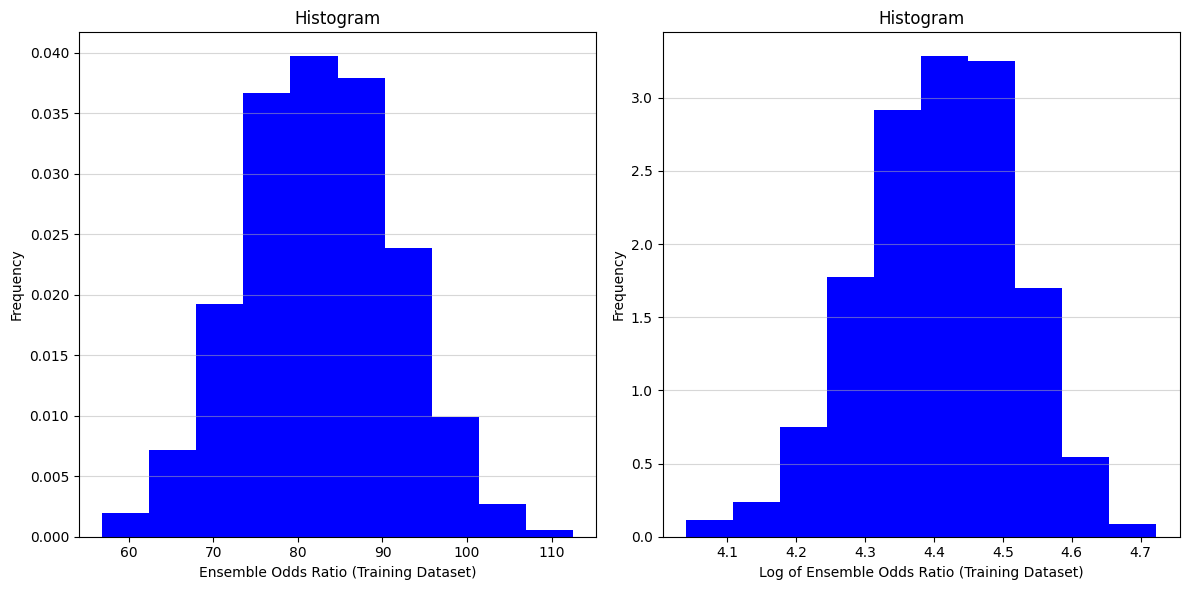

In [7]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot a histogram
axes[0].hist(ensemble_odds_ratio_train, density=True, color='b')
axes[0].set_xlabel('Ensemble Odds Ratio (Training Dataset)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram')
axes[0].grid(axis='y', alpha=0.5)

axes[1].hist(np.log(ensemble_odds_ratio_train), density=True, color='b')
axes[1].set_xlabel('Log of Ensemble Odds Ratio (Training Dataset)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram')
axes[1].grid(axis='y', alpha=0.5)

# Plot a KDE plot
# sns.kdeplot(np.log(ensemble_odds_ratio_train), fill=True, ax=axes[1])
# axes[1].set_xlabel('Ensemble Odds Ratio')
# axes[1].set_ylabel('Density')
# axes[1].set_title('KDE Plot')
# axes[1].grid(axis='y', alpha=0.5)

plt.tight_layout()
plt.show()

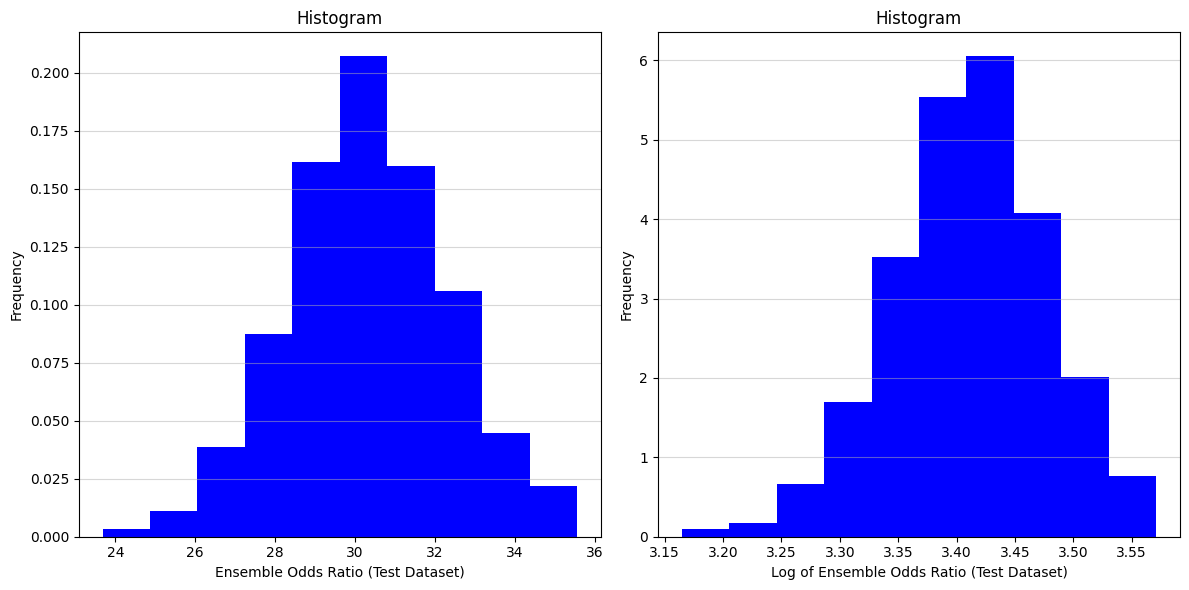

In [8]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot a histogram
axes[0].hist(ensemble_odds_ratio_test, density=True, color='b')
axes[0].set_xlabel('Ensemble Odds Ratio (Test Dataset)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram')
axes[0].grid(axis='y', alpha=0.5)

axes[1].hist(np.log(ensemble_odds_ratio_test), density=True, color='b')
axes[1].set_xlabel('Log of Ensemble Odds Ratio (Test Dataset)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram')
axes[1].grid(axis='y', alpha=0.5)

# Plot a KDE plot
# sns.kdeplot(np.log(ensemble_odds_ratio_train), fill=True, ax=axes[1])
# axes[1].set_xlabel('Ensemble Odds Ratio')
# axes[1].set_ylabel('Density')
# axes[1].set_title('KDE Plot')
# axes[1].grid(axis='y', alpha=0.5)

plt.tight_layout()
plt.show()

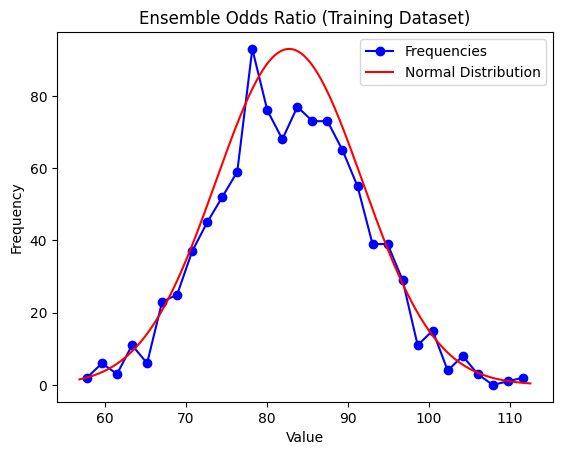

       Mean: 82.73886120783955
       Variance: 81.64696118398066


In [17]:
data = ensemble_odds_ratio_train
hist, bins = np.histogram(data,bins=30)
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(bin_centers, hist, marker='o', linestyle='-', color='b', label='Frequencies')
mean = np.mean(data)
variance = np.var(data)
x = np.linspace(min(data), max(data), 1000)
normal_curve = norm.pdf(x, mean, np.sqrt(variance))
area_under_hist = np.max(hist)
area_under_normal = np.max(normal_curve)
normal_curve *= (area_under_hist/area_under_normal)

plt.plot(x, normal_curve, 'r-', label='Normal Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Ensemble Odds Ratio (Training Dataset)')
plt.legend()
plt.show()
print("       Mean:", mean)
print("       Variance:", variance)

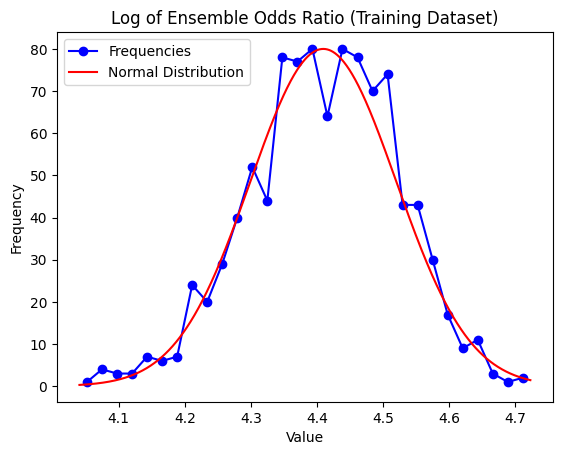

       Mean: 4.409645073700858
       Variance: 0.012205144675561755


In [19]:
data = np.log(ensemble_odds_ratio_train)
hist, bins = np.histogram(data,bins=30)
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(bin_centers, hist, marker='o', linestyle='-', color='b', label='Frequencies')
mean = np.mean(data)
variance = np.var(data)
x = np.linspace(min(data), max(data), 1000)
normal_curve = norm.pdf(x, mean, np.sqrt(variance))
area_under_hist = np.max(hist)
area_under_normal = np.max(normal_curve)
normal_curve *= (area_under_hist/area_under_normal)

plt.plot(x, normal_curve, 'r-', label='Normal Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Log of Ensemble Odds Ratio (Training Dataset)')
plt.legend()
plt.show()
print("       Mean:", mean)
print("       Variance:", variance)

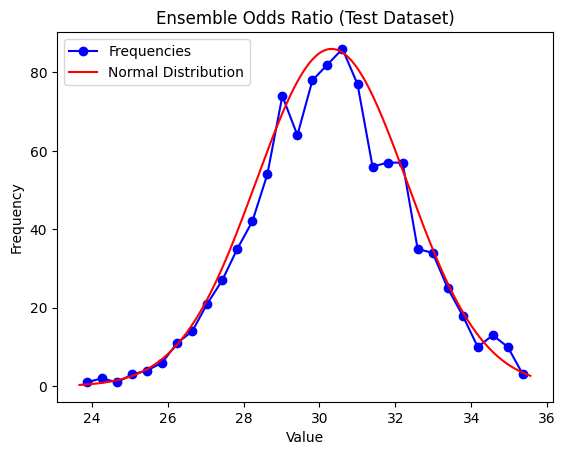

       Mean: 30.316436611505377
       Variance: 3.9492116672249162


In [20]:
data = ensemble_odds_ratio_test
hist, bins = np.histogram(data,bins=30)
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(bin_centers, hist, marker='o', linestyle='-', color='b', label='Frequencies')
mean = np.mean(data)
variance = np.var(data)
x = np.linspace(min(data), max(data), 1000)
normal_curve = norm.pdf(x, mean, np.sqrt(variance))
area_under_hist = np.max(hist)
area_under_normal = np.max(normal_curve)
normal_curve *= (area_under_hist/area_under_normal)

plt.plot(x, normal_curve, 'r-', label='Normal Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Ensemble Odds Ratio (Test Dataset)')
plt.legend()
plt.show()
print("       Mean:", mean)
print("       Variance:", variance)

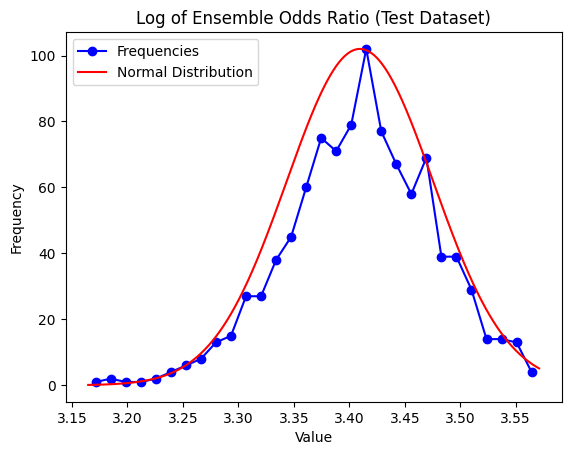

        Mean: 3.4095226356287074
        Variance: 0.004358671570555493


In [22]:
# Calculate the frequency of each value
data = np.log(ensemble_odds_ratio_test)

# Calculate the histogram with 30 bins
hist, bins = np.histogram(data,bins=30)

# Calculate the bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot the frequencies
plt.plot(bin_centers, hist, marker='o', linestyle='-', color='b', label='Frequencies')

# Calculate mean and variance
mean = np.mean(data)
variance = np.var(data)

# Generate the normal distribution curve
x = np.linspace(min(data), max(data), 1000)
normal_curve = norm.pdf(x, mean, np.sqrt(variance))

# Normalize the normal curve to match the frequency scale
area_under_hist = np.max(hist)
area_under_normal = np.max(normal_curve)
normal_curve *= (area_under_hist/area_under_normal)

# Plot the normal distribution
plt.plot(x, normal_curve, 'r-', label='Normal Distribution')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Log of Ensemble Odds Ratio (Test Dataset)')
plt.legend()
plt.show()

print("        Mean:", mean)
print("        Variance:", variance)

In [13]:
ks_statistic, p_value = ks_2samp(np.log(ensemble_odds_ratio_train), np.log(ensemble_odds_ratio_test))

In [14]:
ks_statistic

1.0

In [15]:
p_value

0.0

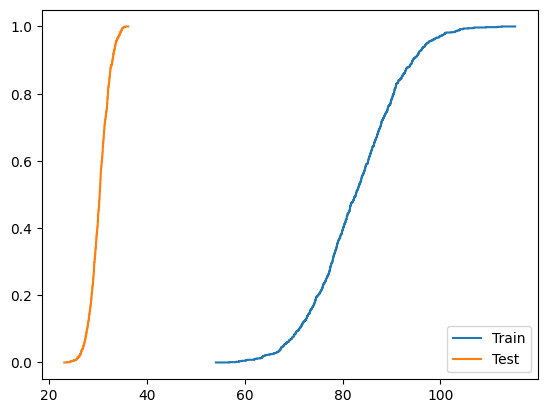

In [16]:
res_train = stats.ecdf(ensemble_odds_ratio_train)
ax = plt.subplot()
res_train.cdf.plot(ax)
res_test = stats.ecdf(ensemble_odds_ratio_test)
res_test.cdf.plot(ax)
ax.legend(['Train','Test'])
plt.show()